## Analisis Exploratio de datos

In [1]:
!Conda info


     active environment : practica_ml
    active env location : /Users/JuditLozano/opt/anaconda3/envs/practica_ml
            shell level : 2
       user config file : /Users/JuditLozano/.condarc
 populated config files : /Users/JuditLozano/.condarc
          conda version : 4.10.3
    conda-build version : 3.21.6
         python version : 3.8.12.final.0
       virtual packages : __osx=10.16=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /Users/JuditLozano/opt/anaconda3  (writable)
      conda av data dir : /Users/JuditLozano/opt/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /Users/JuditLozano/opt/anaconda3/pkgs
              

### Libraries

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from dython.nominal import associations
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from matplotlib import pyplot
from numpy import where
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
import warnings
import pickle
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Funciones

### Objetivo

El dataset contiene información sobre el numero de accidentes de trafico en Canada desde el año 1999 hasta el año 2014.

El objetivo de este estudio es encontrar un modelo que prediga si habrá fallecimientos o no entre los asegurados para ser capaces de pronosticar el capital necesario que debería ser inmovilizado en base a ello. Inmovilizar más capital de lo necesario se traduce en perdidas para la empresa ya que ese exceso de capital podría ser rentabilizado en otros proyectos. 

Asi mismo, no cumplir con el minimo capital necesario para cubrir las indemnizaciones de los accidentes que causan algun fallecimiento puede significar multas importantes para la empresa o incluso la quiebra. 

Tras un analisis inicial las variables disponibles antes de que se produzca un accidente corresponden a las de la lista "list_columns".

Las columnas que no usamos en el siguiente estudio son las siguientes. 

excluded_columns = ["C_VEHS", "C_CONF", "V_ID", "P_ID", "P_ISEV", "P_USER"]

No las hemos incluido porque no aportar valor (como los IDs) o porque son datos que no se se podrían utilizar en nuestro modelo predictorio porque son datos que no están disponibles antes de que haya un accidente que es cuando el modelo se va a implantar.

In [3]:
list_columns = ["C_YEAR", "C_MNTH", "C_WDAY", "C_HOUR", "C_SEV", "C_RCFG", "C_WTHR", "C_RSUR", "C_RALN", "C_TRAF", "V_TYPE", "V_YEAR", "P_SEX", "P_AGE", "P_PSN", "P_SAFE"]

data = pd.read_csv("Datos/NCDB_1999_to_2014.csv").loc[:, list_columns]

data.shape

(5860405, 16)

In [4]:
data.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_SAFE
0,1999,1,1,20,2,UU,1,5,3,03,06,1990,M,41,11,UU
1,1999,1,1,20,2,UU,1,5,3,03,01,1987,M,19,11,UU
2,1999,1,1,20,2,UU,1,5,3,03,01,1987,F,20,13,02
3,1999,1,1,08,2,UU,5,3,6,18,01,1986,M,46,11,UU
4,1999,1,1,08,2,UU,5,3,6,18,NN,NNNN,M,05,99,UU


Observamos los tipos de las variables del dataset y el nombre de las columnas

In [5]:
data.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_TYPE    object
V_YEAR    object
P_SEX     object
P_AGE     object
P_PSN     object
P_SAFE    object
dtype: object

In [6]:
data.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_RCFG', 'C_WTHR',
       'C_RSUR', 'C_RALN', 'C_TRAF', 'V_TYPE', 'V_YEAR', 'P_SEX', 'P_AGE',
       'P_PSN', 'P_SAFE'],
      dtype='object')

In [25]:
df_data = data

En el dataset cada fila corresponde a una persona que estuvo involucrada en un accidente. Es decir, cada registro puede hacer referencia al conductor, a alguien que viajaba en la segunda fila, en la tercera fila o incluso a un peatón que pasaba por alli.  

Dado que el objetivo de este estudio es centrarse en los conductores para intentar predecir que tipo de conductores tendrían más posibilidades de sufrir un accidente que resultara en algún fallecido, crearemos una nueva variable que identifique a los conductores según la clase 'driver' de la variable P_PSN y eliminaremos del dataset los registros que hacen referencia a los no conductores. 

Igualmente, filtraremos el dataset por accidentes con resultado mortal y crearemos nuestra variable 'Target' que identifica a los conductores involucrados en un accidente donde hubo algún fallecido con un 1 y conductores que tuvieron un accidente pero sin fallecidos con un 0. 

In [26]:
df_data['DRIVERS'] = np.where(df_data['P_PSN']=='11',1,0) #identifico las filas de tipo 'conductor'
mask_drivers = df_data['DRIVERS']==1
df_data = df_data[mask_drivers] #filtro para ver solo los registros de tipo conductor
df_data['TARGET'] = np.where(df_data['C_SEV']==1,1,0) #identifico a los conductores involucrados en un accidente donde hubo algún fallecido

### Exploración de la variable objetivo

Aqui se observa un desbalanceo significanivo de los datos ya que tan solo un 1.46% de los conductores ha estado involucrado en algun accidente donde hubo al menos un fallecido. Este desbalanceo se tratará más adelante.

In [27]:
df_plot_target = df_data['TARGET'] \
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()
        
df_plot_conteo = df_data['TARGET'].value_counts().rename('conteo').reset_index()


df_plot_fatalities = pd.merge(df_plot_target, df_plot_conteo, on=['index'], how='inner')
df_plot_fatalities

,index,percent,conteo
0,0,98.543155,3868889
1,1,1.456845,57197


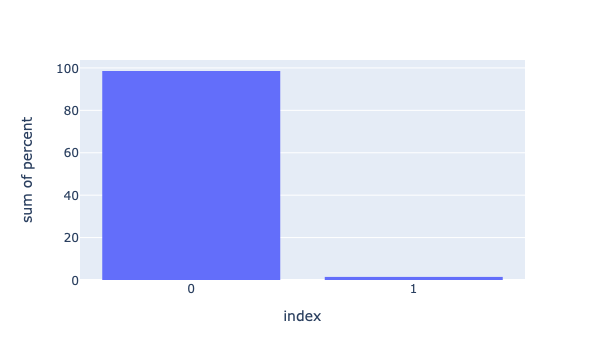

In [28]:
fig = px.histogram(df_plot_fatalities, x='index', y='percent')
fig.update_xaxes(type='category')
fig.show()

Observamos si hay alguna columna duplicada en el dataframe

In [11]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups 
    dups = []
    
    for t, v in groups.items():
        cs = frame[v].columns 
        vs = frame[v]
        lcs = len(cs)
        
        for i in range(lcs):
            ia = vs.iloc[:,i].values 
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values 
                if np.array_equal(ia, ja):
                    dups.append(cs[i]) 
                    break
                
    return dups

In [22]:
duplicate_cols = duplicate_columns(df_data)
duplicate_cols

[]

### Preprocesamiento inicial de las variables:
Observamos que no hay valores nulos en el dataset.

In [29]:
#analizarnulos
df_dtypes = pd.merge(df_data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(), 
                     df_data.dtypes.to_frame('feature_type').reset_index(),
                     on = 'index', how = 'inner')
df_dtypes

,index,missing_value,feature_type
0,C_YEAR,0,int64
1,P_SAFE,0,object
2,P_PSN,0,object
3,P_AGE,0,object
4,P_SEX,0,object
5,V_YEAR,0,object
6,V_TYPE,0,object
7,C_TRAF,0,object
8,C_RALN,0,object
9,C_RSUR,0,object


Nos hacemos una idea del tipo de valores unicos que tenemos en cada columna y observamos que son de tipo discreto, es decir no son valores que se puedan fraccionar. Por lo tanto, pasamos a unificar los valores de las variables a enteros para facilitar el procesamiento de datos.

In [30]:
for col in df_data:
    print(df_data[col].value_counts(normalize=True))

2000    0.071728
2002    0.071468
1999    0.069930
2003    0.069761
2001    0.069519
2004    0.067055
2005    0.066963
2006    0.065196
2007    0.063130
2008    0.057719
2009    0.055925
2010    0.055811
2012    0.054945
2011    0.054857
2013    0.054456
2014    0.051537
Name: C_YEAR, dtype: float64
8     0.091139
7     0.089455
6     0.089346
10    0.088654
9     0.088646
11    0.085582
5     0.080390
2     0.071606
3     0.071308
4     0.067185
12    0.047317
01    0.045274
1     0.041045
12    0.041045
02    0.001630
11    0.000326
UU    0.000053
Name: C_MNTH, dtype: float64
5    0.088700
5    0.083245
4    0.078101
4    0.077069
3    0.075144
1    0.074579
2    0.073214
2    0.073107
3    0.072873
6    0.070833
6    0.063344
1    0.062530
7    0.058854
7    0.048178
U    0.000229
Name: C_WDAY, dtype: float64
16    0.090049
17    0.086355
15    0.083656
14    0.067696
12    0.063354
13    0.062690
18    0.061996
08    0.056080
11    0.052374
19    0.045046
10    0.044189
09    0.041

In [19]:
unknowns_a = {'UU' : 50, 'XX' : 51, 'U' : 52, 'X' : 53, 'NN' : 54, 'Q' : 55, 'QQ' : 56}
unknowns_year = { 'UUUU' : 2100,'XXXX' : 2101, 'NNNN' : 2102}
unknowns_age = {'UU' : 150, 'XX' : 151, 'NN' : 152, 'QQ' : 153}
unknowns_sex = {'U' : 8, 'N' : 9, 'M' : 0, 'F' : 1}

In [20]:
df_data.columns

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
       'C_TRAF', 'V_TYPE', 'P_SAFE', 'V_YEAR', 'C_YEAR', 'P_AGE', 'P_SEX',
       'TARGET'],
      dtype='object')

In [21]:
col_cat_a = ["C_MNTH", "C_WDAY", "C_HOUR", "C_RCFG", "C_WTHR", "C_RSUR", "C_RALN", "C_TRAF", "V_TYPE", "P_SAFE"]
col_cat_year = ["V_YEAR", 'C_YEAR']
col_cat_age = ["P_AGE"]
col_cat_sex = ["P_SEX"]

In [22]:
df_col_a = df_data[col_cat_a].replace(unknowns_a).astype(object)
df_col_year = df_data[col_cat_year].replace(unknowns_year).astype(int)
df_col_age = df_data[col_cat_age].replace(unknowns_age).astype(int)
df_col_sex = df_data[col_cat_sex].replace(unknowns_sex).astype(object)
df_data = pd.concat([df_col_a, df_col_year, df_col_age, df_col_sex, df_data['TARGET']], axis=1).reset_index(drop=True)
df_data.shape

(3926086, 15)

In [23]:
#confirmamos que no hay nulos y el cambio de tipo a int
no_nulos = pd.merge(df_data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(), 
                     df_data.dtypes.to_frame('feature_type').reset_index(),
                     on = 'index', how = 'inner')
no_nulos

,index,missing_value,feature_type
0,C_MNTH,0,object
1,C_WDAY,0,object
2,C_HOUR,0,object
3,C_RCFG,0,object
4,C_WTHR,0,object
5,C_RSUR,0,object
6,C_RALN,0,object
7,C_TRAF,0,object
8,V_TYPE,0,object
9,P_SAFE,0,object


In [24]:
for col in df_data:
    print(df_data[col].value_counts(normalize=True))

8     0.091139
7     0.089455
6     0.089346
10    0.088654
9     0.088646
12    0.088362
1     0.086319
11    0.085908
5     0.080390
2     0.073237
3     0.071308
4     0.067185
50    0.000053
Name: C_MNTH, dtype: float64
5     0.171945
4     0.155170
3     0.148017
2     0.146321
1     0.137109
6     0.134177
7     0.107031
52    0.000229
Name: C_WDAY, dtype: float64
16    0.090049
17    0.086355
15    0.083656
14    0.067696
12    0.063354
13    0.062690
18    0.061996
8     0.056080
11    0.052374
19    0.045046
10    0.044189
9     0.041896
7     0.040329
20    0.034151
21    0.031958
22    0.025644
6     0.020785
23    0.019753
0     0.013686
2     0.011595
1     0.011342
50    0.010307
3     0.009992
5     0.008306
4     0.006772
Name: C_HOUR, dtype: float64
2     0.469632
1     0.355050
50    0.085282
3     0.048491
56    0.024212
5     0.009289
4     0.004394
8     0.002024
6     0.001098
9     0.000299
7     0.000164
10    0.000066
Name: C_RCFG, dtype: float64
1     0.694780

In [38]:
# nos guardamos la tabla a CSV
df_data.to_csv('datos/df_data.csv', index=False)

In [26]:
# For kicks read our output back into Python and make sure all looks good
#df_data = pd.read_csv('datos/df_data.csv', keep_default_na=False, na_values=[""])

In [27]:
df_data.head()

,C_MNTH,C_WDAY,C_HOUR,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE,V_YEAR,C_YEAR,P_AGE,P_SEX,TARGET
0,1,1,20,50,1,5,3,3,6,50,1990,1999,41,0,0
1,1,1,20,50,1,5,3,3,1,50,1987,1999,19,0,0
2,1,1,8,50,5,3,6,18,1,50,1986,1999,46,0,0
3,1,1,17,56,1,2,1,1,1,50,1984,1999,28,0,0
4,1,1,17,56,1,2,1,1,1,50,1991,1999,21,0,0


In [35]:
df_data.dtypes

C_MNTH    object
C_WDAY    object
C_HOUR    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_TYPE    object
P_SAFE    object
V_YEAR     int64
C_YEAR     int64
P_AGE      int64
P_SEX     object
TARGET     int64
dtype: object

### Análisis gráfico del resto de variables

In [28]:
def plot_feature(col_name, isNumeric): 
    """
    Visualize a variable with and without faceting on the fatalities yes/no. - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - numeric is True if the variable is numeric, False otherwise 
    """

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)

    # Plot without TARGET
    if isNumeric:
        sns.distplot(df_data.loc[df_data[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df_data[col_name], order=sorted(df_data[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name) 
    ax1.set_ylabel('Count') 
    ax1.set_title(col_name) 

    # Plot with TARGET
    if isNumeric:
        sns.kdeplot(x=df_data[col_name].loc[df_data['TARGET']== 0],
           shade= True, label='no_fatalities')
        sns.kdeplot(df_data[col_name].loc[df_data['TARGET']== 1],
            shade= True, label='fatalities')
        plt.legend()
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by TARGET')
        
    
    else:
        plt_data = df_data.groupby(col_name)['TARGET'].value_counts(normalize=True).to_frame('proportion').reset_index() 
        sns.barplot(x = col_name, y = 'proportion', hue= "TARGET", data = plt_data, saturation=1, ax=ax2) 
        ax2.set_ylabel('TARGET fraction')
        ax2.set_title('TARGET')
        ax2.set_xlabel(col_name) 
    plt.tight_layout()


In [29]:
df_data.columns

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
       'C_TRAF', 'V_TYPE', 'P_SAFE', 'V_YEAR', 'C_YEAR', 'P_AGE', 'P_SEX',
       'TARGET'],
      dtype='object')

In [30]:
df_cat = df_data[["C_MNTH", "C_WDAY", "C_HOUR", "C_RCFG", "C_WTHR", "C_RSUR", "C_RALN", "C_TRAF", "V_TYPE", "P_SAFE", "P_SEX"]]

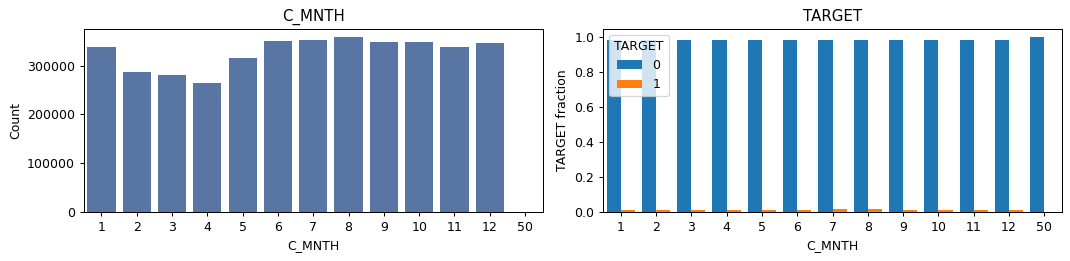

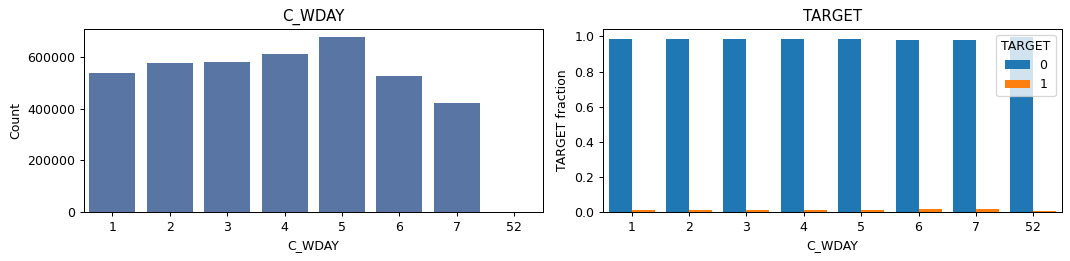

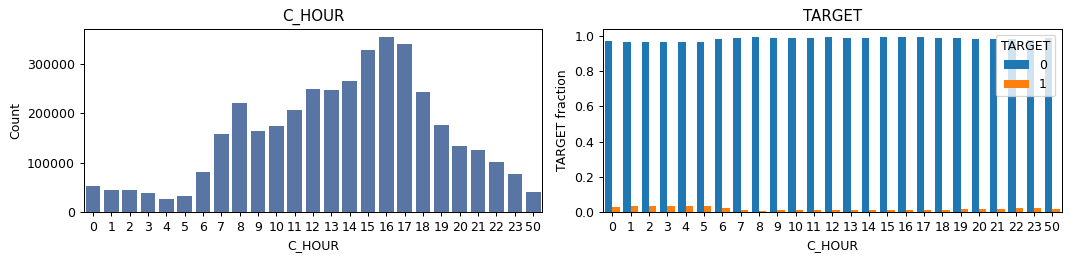

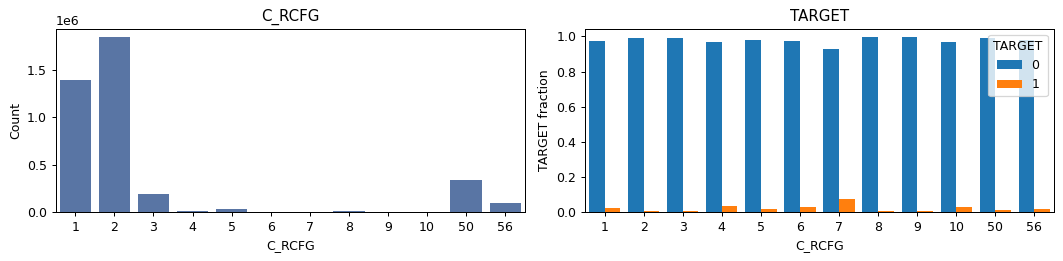

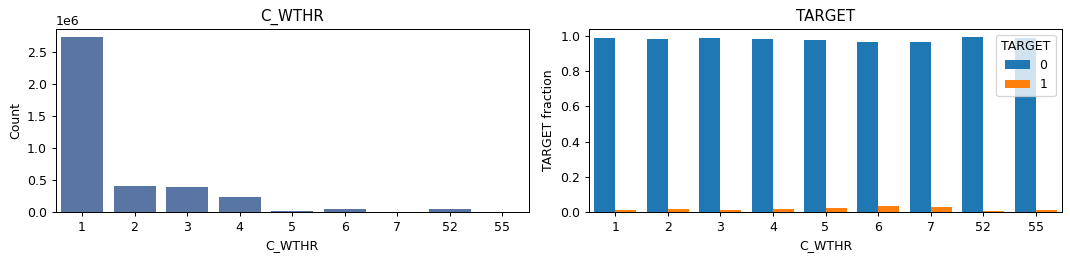

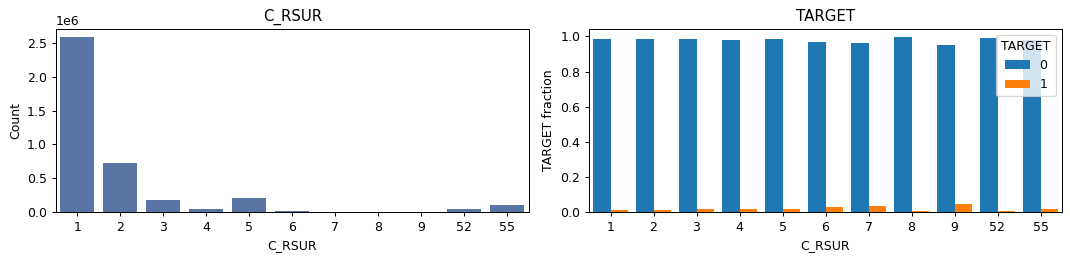

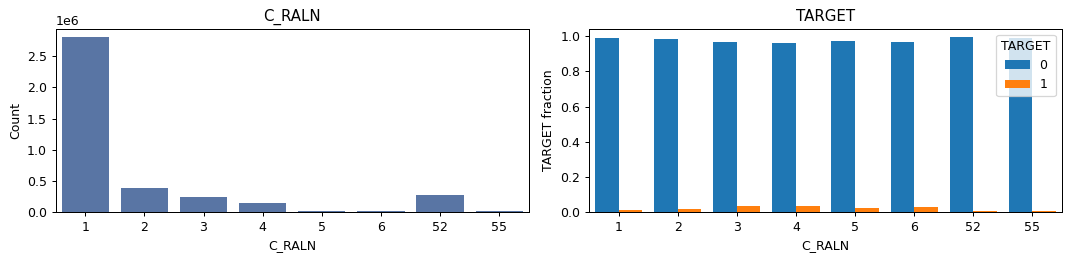

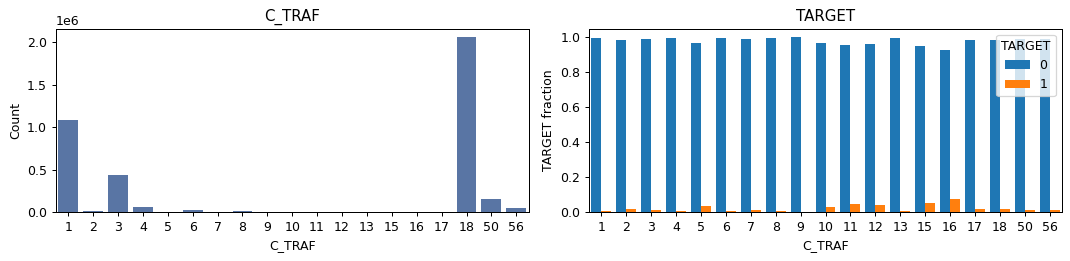

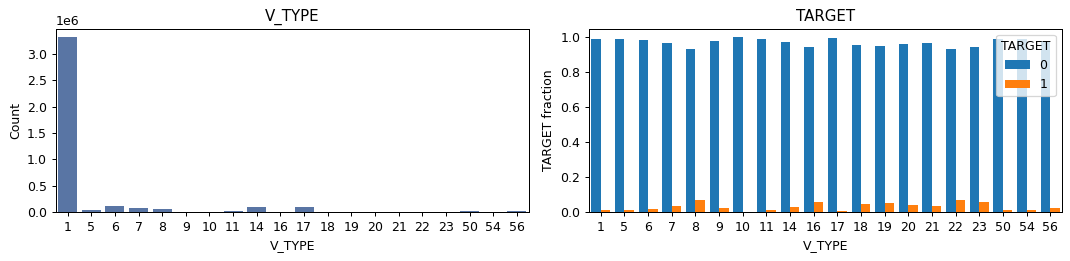

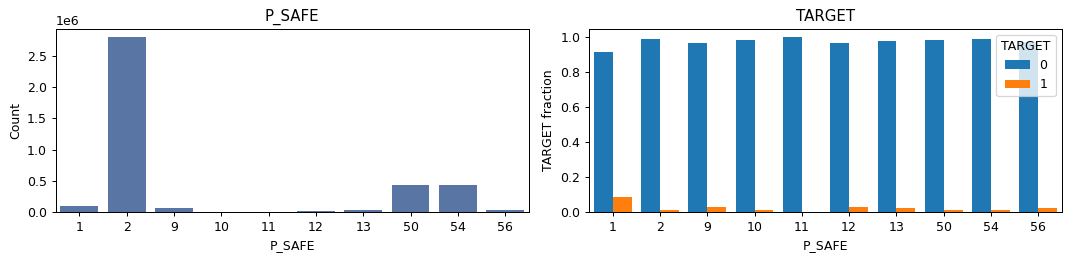

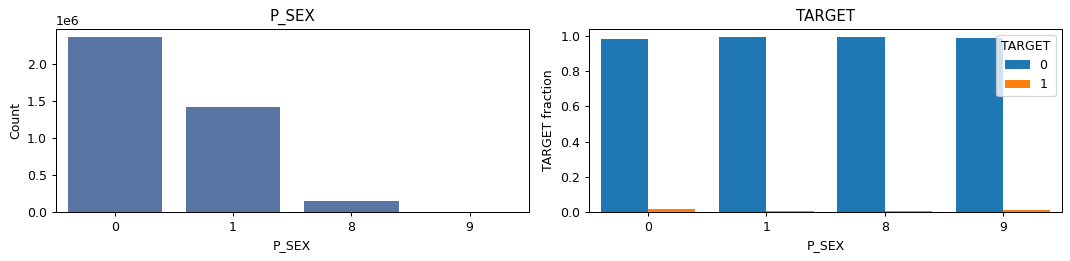

In [31]:
for col in df_cat:
    plot_feature(col, False)

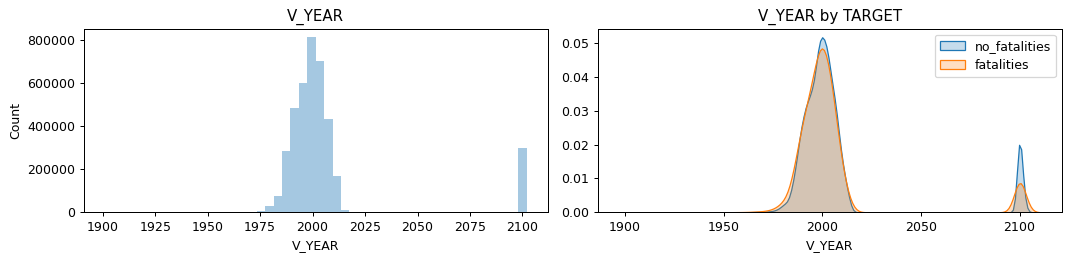

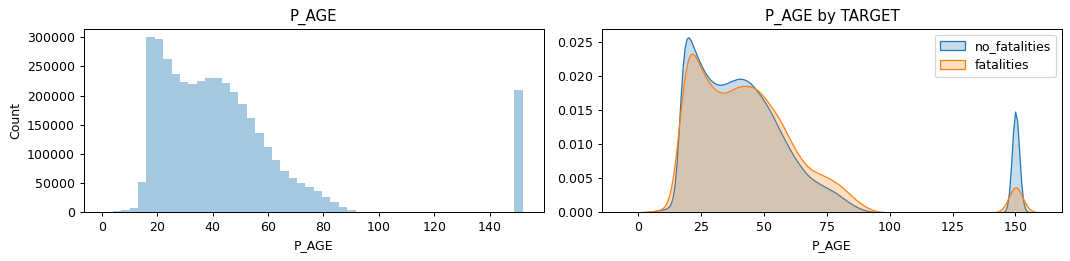

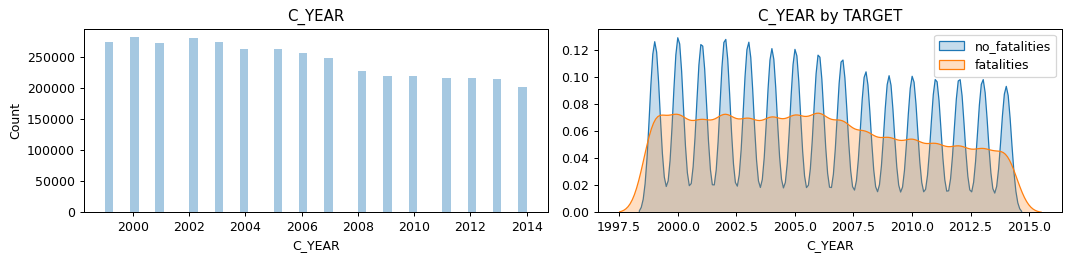

In [32]:
df_num = df_data[['V_YEAR', 'P_AGE', 'C_YEAR']]

for col in df_num:
    plot_feature(col, True)

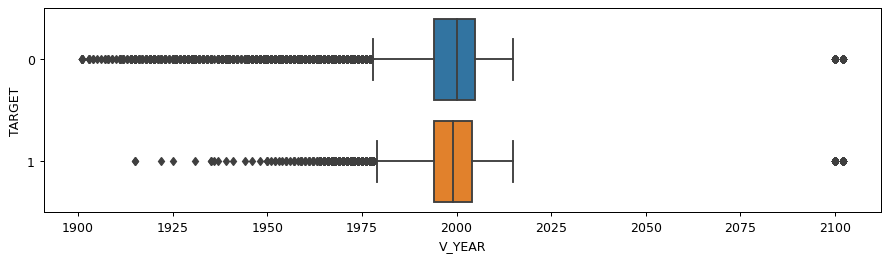

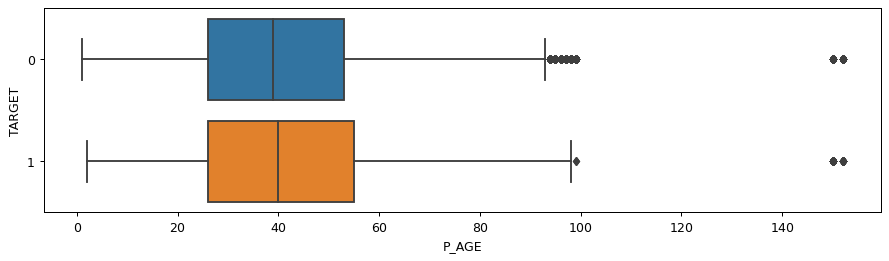

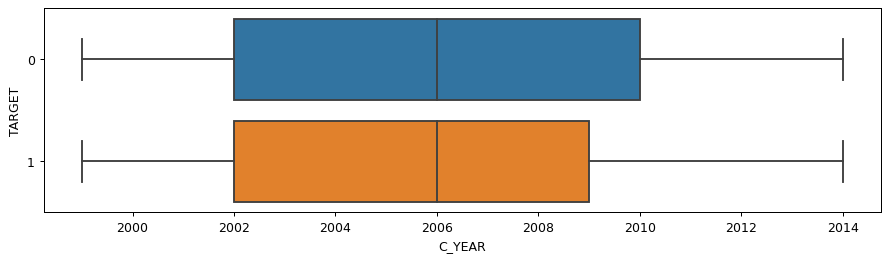

In [33]:
# Plot boxplots
for col in df_num:
    f, ax1 = plt.subplots(figsize=(12,3), dpi=90)
    ax = sns.boxplot(x=col, y='TARGET', data=df_data, orient="h")
    ax.get_yaxis().set_visible(True)

### Medidas de asociacion entre las variablies categoricas: cramers_v

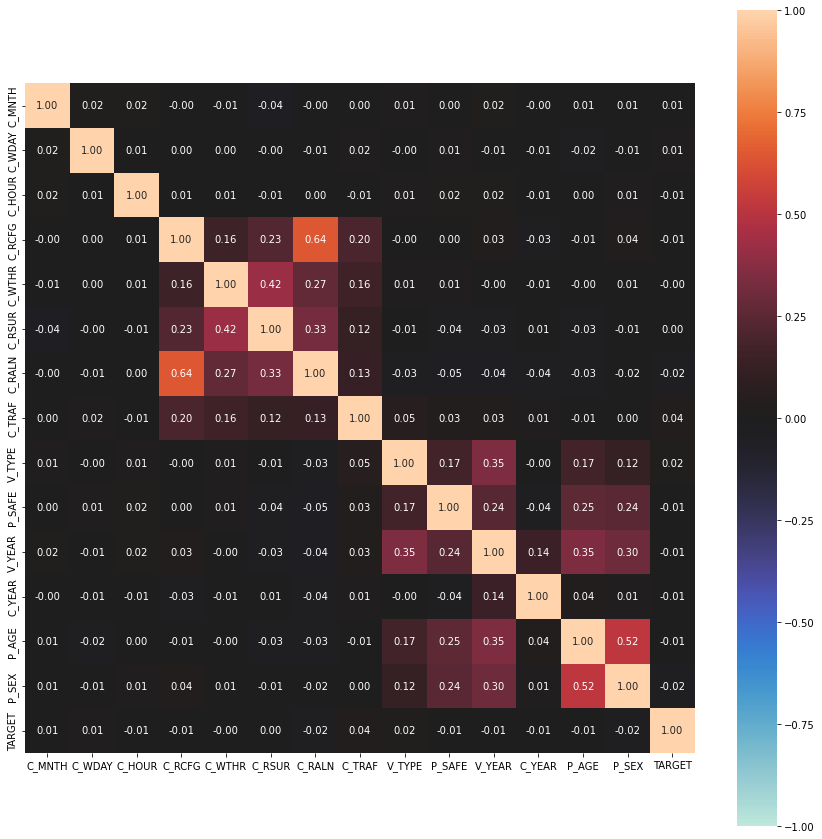

{'corr':           C_MNTH    C_WDAY    C_HOUR    C_RCFG    C_WTHR    C_RSUR    C_RALN  \
 C_MNTH  1.000000  0.020906  0.020242 -0.002399 -0.007910 -0.040358 -0.004737   
 C_WDAY  0.020906  1.000000  0.006097  0.002401  0.000589 -0.003143 -0.005046   
 C_HOUR  0.020242  0.006097  1.000000  0.006172  0.006222 -0.009705  0.004767   
 C_RCFG -0.002399  0.002401  0.006172  1.000000  0.155620  0.225975  0.641408   
 C_WTHR -0.007910  0.000589  0.006222  0.155620  1.000000  0.418858  0.269157   
 C_RSUR -0.040358 -0.003143 -0.009705  0.225975  0.418858  1.000000  0.328008   
 C_RALN -0.004737 -0.005046  0.004767  0.641408  0.269157  0.328008  1.000000   
 C_TRAF  0.002205  0.015145 -0.010318  0.201545  0.161749  0.119248  0.129725   
 V_TYPE  0.009132 -0.003745  0.011106 -0.000122  0.010652 -0.012018 -0.025891   
 P_SAFE  0.003117  0.014274  0.022120  0.004052  0.012922 -0.037260 -0.046449   
 V_YEAR  0.021267 -0.009257  0.019838  0.028137 -0.004945 -0.030596 -0.044936   
 C_YEAR -0.000029 -0

In [34]:
# Plot features associations

associations(df_data, nom_nom_assoc='cramer', figsize=(15, 15))

### Dividimos el dataset en train y test
Dividimos el dataset en train y test manteniendo la proporción de la variable objetivo en las dos partes (separación estratificada)

In [46]:
X = df_data.drop('TARGET',axis=1)
y = df_data['TARGET']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.20, random_state=0)

In [48]:
#comprobación de la estratificación
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.985431
1    0.014569
Name: TARGET, dtype: float64
0    0.985432
1    0.014568
Name: TARGET, dtype: float64


### Modelo base (decisión al azar)

Usaremos este estimador para comparar el resultado con el de nuestros modelos más avanzados. Para que los modelos que utilizaremos posteriormente sean válidos deben alcanzar una métrica superior a la de este estimador:

In [49]:
#librerias hay que moverlas
from sklearn.dummy import DummyClassifier
from collections import Counter

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [50]:
def print_binary_evaluation(y_true, y_pred):
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

In [51]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

{'accuracy': 0.014567928906367404,
 'recall': 1.0,
 'precision': 0.014567928906367404,
 'f1_score': 0.02871750326677604}

Con este modelo 'tonto' le indicamos al algoritmo que sin tener en cuenta ningún patrón ni valor entre nuestras variables explicativas, prediga nuestra clase no mayoritaria, en este caso 1. Como observamos obtenemos una f1_score muy baja que nos idicarían que las predicciones no son fiables usando éste método 'al azar'. 